In [1]:
import os
if os.getcwd() != 'pwd':
   %cd ../..

/home/guorui/ICSDICE


/home/guorui/miniconda3/envs/ICSDICE/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import os

import yaml

os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax.numpy as jnp
import jax
import optax
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)


def create_coordinate_set(x1, y1, x2, y2):
    if x1 == x2:
        coords = [
            (x1, i)
            for i in range(y1, y2 + (-1 if y1 > y2 else 1), -1 if y1 > y2 else 1)
        ]
    elif y1 == y2:
        coords = [
            (i, y1)
            for i in range(x1, x2 + (-1 if x1 > x2 else 1), -1 if x1 > x2 else 1)
        ]
    return np.array(coords)


def generate_random_path(grid, start, ends):
    def find_path(current_position, visited):
        if current_position in ends:
            return [current_position]

        possible_moves = []
        row, col = current_position
        rows, cols = grid.shape

        if row > 0 and grid[row - 1, col] == 1 and (row - 1, col) not in visited:
            possible_moves.append((-1, 0))
        if row < rows - 1 and grid[row + 1, col] == 1 and (row + 1, col) not in visited:
            possible_moves.append((1, 0))
        if col > 0 and grid[row, col - 1] == 1 and (row, col - 1) not in visited:
            possible_moves.append((0, -1))
        if col < cols - 1 and grid[row, col + 1] == 1 and (row, col + 1) not in visited:
            possible_moves.append((0, 1))

        if (
            row > 0
            and col > 0
            and grid[row - 1, col - 1] == 1
            and (row - 1, col - 1) not in visited
        ):
            possible_moves.append((-1, -1))
        if (
            row > 0
            and col < cols - 1
            and grid[row - 1, col + 1] == 1
            and (row - 1, col + 1) not in visited
        ):
            possible_moves.append((-1, 1))
        if (
            row < rows - 1
            and col > 0
            and grid[row + 1, col - 1] == 1
            and (row + 1, col - 1) not in visited
        ):
            possible_moves.append((1, -1))
        if (
            row < rows - 1
            and col < cols - 1
            and grid[row + 1, col + 1] == 1
            and (row + 1, col + 1) not in visited
        ):
            possible_moves.append((1, 1))

        if not possible_moves:
            return []

        next_move = possible_moves[np.random.choice(len(possible_moves))]
        new_position = (
            current_position[0] + next_move[0],
            current_position[1] + next_move[1],
        )
        path = find_path(new_position, visited + [current_position])

        return [current_position] + path if path is not None else None

    path = find_path(start, [])
    return np.array(path) if path is not None else None


grid_shape = (7, 7)


def get_data(
    expert_d, expert_trajs, end_point, sample_trajs, gamma, state_ocuupy_E, rho
):
    d_end = np.zeros(grid_shape)
    d_end[end_point] = 1

    def calculate_traj_distances(traj):
        r = (traj[1:] == end_point).all(axis=1) - 1

        d = np.power(gamma, np.arange(len(traj) - 1))
        return d, r

    target_E = np.concatenate(
        [
            expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
            for traj in expert_trajs
        ]
    )
    target_S = np.concatenate(
        [
            expert_d[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
            for traj in sample_trajs
        ]
    )

    def get_all_data(trajs, rho):
        _, r = list(zip(*[calculate_traj_distances(traj) for traj in trajs]))
        r = np.concatenate(r)
        index = np.concatenate([np.arange(len(traj) - 1) for traj in trajs])
        rho = np.concatenate(
            [
                rho[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]]
                for traj in trajs
            ]
        )
        return rho, index, r

    show_S = np.concatenate(
        [state_ocuupy_E[traj[:-1:, 0], traj[:-1, 1]] != 0 for traj in sample_trajs]
    )
    rho_E, index_E, r_E = get_all_data(expert_trajs, rho)
    rho_S, index_S, r_S = get_all_data(sample_trajs, rho)

    obs_E = np.concatenate([traj[:-1] for traj in expert_trajs])
    obs_next_E = np.concatenate([traj[1:] for traj in expert_trajs])

    obs_S = np.concatenate([traj[:-1] for traj in sample_trajs])
    obs_next_S = np.concatenate([traj[1:] for traj in sample_trajs])
    return (
        index_E,
        index_S,
        target_E,
        target_S,
        show_S,
        r_E,
        r_S,
        obs_E,
        obs_next_E,
        obs_S,
        obs_next_S,
        d_end,
    )



def omega_star(y):
    return (y > -2) * (y / 2 + 1)


def fp_star(y):
    return (y > -2) * (y * (y + 4) / 4)


cost_limit = 0.9


def solve_V(settingname, gamma, beta, sparse_alpha, cost_l2):
    expert_trajs = np.load(f"dataset/grid_world/{settingname}/expert_trajs.npz")
    expert_trajs = [expert_trajs[name] for name in expert_trajs.files]

    with open(f"dataset/grid_world/{settingname}.yaml") as f:
        config = yaml.safe_load(f)

    start_point = tuple(expert_trajs[0][0].tolist())
    end_point = tuple(expert_trajs[0][-1].tolist())
    ab_points = list(map(tuple, config["terminal_states"]))
    sample_trajs = []
    random_path = [
        generate_random_path(np.ones(grid_shape), start_point, ab_points) for i in range(10)
    ]
    sample_trajs += random_path
    random_path = [
        generate_random_path(np.ones(grid_shape), (0, 5), ab_points) for i in range(10)
    ]
    sample_trajs += random_path
    random_path = [
        generate_random_path(np.ones(grid_shape), (6, 1), ab_points) for i in range(10)
    ]
    sample_trajs += random_path
    random_path = [
        generate_random_path(np.ones(grid_shape), (1, 0), ab_points) for i in range(10)
    ]
    sample_trajs += random_path
    random_path = [
        generate_random_path(np.ones(grid_shape), (5, 6), ab_points) for i in range(10)
    ]
    sample_trajs += random_path

    d_ab = np.zeros(grid_shape)
    for point in ab_points:
        d_ab[point] = 1

    d_0 = np.zeros(grid_shape)
    d_0[start_point] = 1
    rho_S = np.zeros((*grid_shape, *grid_shape))
    rho_E = np.zeros((*grid_shape, *grid_shape))

    for traj in expert_trajs:
        rho_E[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1
    for traj in sample_trajs:
        rho_S[traj[:-1, 0], traj[:-1:, 1], traj[1:, 0], traj[1:, 1]] += 1

    state_ocuupy_E = np.zeros(grid_shape)
    for traj in expert_trajs:
        state_ocuupy_E[traj[:-1, 0], traj[:-1, 1]] += 1

    rho = (beta * rho_E + (1 - beta) * rho_S) / (
        (beta * rho_E + (1 - beta) * rho_S).sum((-1, -2))
    ).clip(0.1)[..., None, None]
    expert_d = rho_E / rho_E.sum((-1, -2)).clip(1)[..., None, None]
    expert_d[(expert_d < 1) & (expert_d > 0)] = 0.5

    (
        index_E,
        index_S,
        target_E,
        target_S,
        show_S,
        r_E,
        r_S,
        obs_E,
        obs_next_E,
        obs_S,
        obs_next_S,
        d_end,
    ) = get_data(
        expert_d, expert_trajs, end_point, sample_trajs, gamma, state_ocuupy_E, rho
    )

    def calculate_y(obs, obs_next, V):
        y = gamma * V[obs_next[:, 0], obs_next[:, 1]] - V[obs[:, 0], obs[:, 1]]
        return y, V[obs[:, 0], obs[:, 1]], V[obs_next[:, 0], obs_next[:, 1]]

    def get_V(V):
        y_E, V_E, next_V_E = calculate_y(obs_E, obs_next_E, V)
        y_S, V_S, next_V_S = calculate_y(obs_S, obs_next_S, V)
        return (y_E, V_E, next_V_E), (y_S, V_S, next_V_S)

    # @jax.jit
    def dualrewardV(reward_V, V):
        (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(reward_V)
        (_, _, next_cost_E), (_, _, next_cost_S) = get_V(V)
        dones_E = d_ab[obs_next_E[:, 0], obs_next_E[:, 1]]
        dones_S = d_ab[obs_next_S[:, 0], obs_next_S[:, 1]]
        return (1 - gamma) * (reward_V * d_0).sum() + (1 - gamma) * (
            sparse_alpha
            * (
                (
                    (next_cost_E <= cost_limit)
                    * beta
                    * (gamma**index_E)
                    * (fp_star((y_E + r_E) / sparse_alpha))
                ).sum()
                / len(expert_trajs)
                + (
                    (next_cost_S <= cost_limit)
                    * (1 - beta)
                    * (gamma**index_S)
                    * (fp_star((y_S + r_S) / sparse_alpha))
                ).sum()
                / len(sample_trajs)
            )
            + sparse_alpha
            * (
                beta
                * (
                    (next_cost_E <= cost_limit)
                    * dones_E
                    * (gamma ** (index_E + 1))
                    / (1 - gamma)
                    * fp_star(
                        (
                            gamma * next_V_E
                            - next_V_E
                            - (d_ab - d_end)[obs_next_E[:, 0], obs_next_E[:, 1]]
                        )
                        / sparse_alpha
                    )
                ).sum()
                / len(expert_trajs)
                + (1 - beta)
                * (
                    (next_cost_S <= cost_limit)
                    * dones_S
                    * (gamma ** (index_S + 1))
                    / (1 - gamma)
                    * fp_star(
                        (
                            gamma * next_V_S
                            - next_V_S
                            - (d_ab - d_end)[obs_next_S[:, 0], obs_next_S[:, 1]]
                        )
                        / sparse_alpha
                    )
                ).sum()
                / len(sample_trajs)
            )
        )

    @jax.jit
    def dualV(V, weight_S):
        (_, cost_E, _), (
            _,
            cost_S,
            _,
        ) = get_V(V)
        return (
            100 * (cost_E**2).mean()
            + (weight_S * (cost_S - 1) ** 2).mean()
            + cost_l2 * (cost_S**2).mean()
        )

    V = jnp.zeros(grid_shape)
    alpha = jnp.zeros(1)
    reward_V = jnp.zeros(grid_shape)
    optimizer = optax.adamw(learning_rate=5e-2)
    opt_state = optimizer.init(V)
    reward_optimizer = optax.adamw(learning_rate=1e-3)
    reward_opt_state = reward_optimizer.init(reward_V)

    @jax.jit
    def reward_step(V, reward_V, opt_state):
        loss_value, grads = jax.value_and_grad(dualrewardV)(reward_V, V)
        updates, opt_state = reward_optimizer.update(grads, opt_state, reward_V)
        reward_V = optax.apply_updates(reward_V, updates)
        return reward_V, opt_state, loss_value

    @jax.jit
    def step(V, weight_S, opt_state):
        loss_value, grads = jax.value_and_grad(dualV)(V, weight_S)
        updates, opt_state = optimizer.update(grads, opt_state, V)
        V = optax.apply_updates(V, updates)
        return V, opt_state, loss_value

    total_weight_S = 0
    occupancys = []
    costs = []
    weights = []
    f_divs = []
    Vs = []
    reward_V = jnp.zeros(grid_shape)
    np.set_printoptions(precision=1)
    for epoch in range(8):
        reward_V = jnp.zeros(grid_shape)
        opt_state = optimizer.init(V)
        reward_opt_state = optimizer.init(reward_V)
        for i in range(20000):
            reward_V, reward_opt_state, loss_value = reward_step(
                V, reward_V, reward_opt_state
            )
        V = jnp.zeros(grid_shape)
        Vs.append(reward_V)
        (y_E, V_E, next_V_E), (y_S, V_S, next_V_S) = get_V(reward_V)
        weight_S = omega_star((y_S + r_S) / sparse_alpha) * (
            1 - (next_V_S > cost_limit)
        )
        weights.append(weight_S * (1 - (next_V_S > cost_limit)))
        total_weight_S = total_weight_S * min(epoch, 1) + (weight_S / weight_S.max())
        total_weight_S = total_weight_S / (epoch + 1)
        visited = obs_S[
            omega_star((y_S + r_S) / sparse_alpha) * (1 - (next_V_S > cost_limit)) > 0
        ]
        state_ocuupy = np.zeros(grid_shape)
        np.add.at(state_ocuupy, (visited[:, 0], visited[:, 1]), 1)
        state_ocuupy = state_ocuupy
        f_divs.append(
            np.abs((state_ocuupy_E > 0) & (state_ocuupy == 0)).sum()
            + np.abs((state_ocuupy_E > 0) ^ (state_ocuupy > 0)).sum() / 2
        )
        for i in range(1000):
            V, opt_state, loss_value = step(V, total_weight_S, opt_state)
        occupancys.append((state_ocuupy > 0).astype(np.int32))
        costs.append(V)
    return occupancys, costs, np.array(f_divs), Vs

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/guorui/miniconda3/envs/ICSDICE/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 614, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/guorui/miniconda3/envs/ICSDICE/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options(
TypeError: generate_pjrt_gpu_plugin_options() takes 0 positional arguments but 1 was given


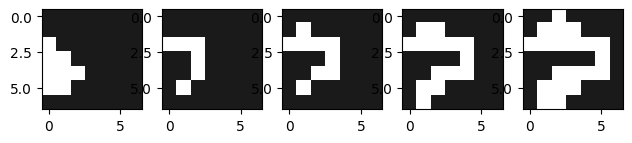

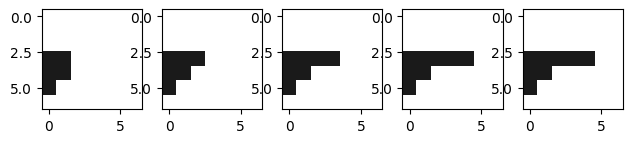

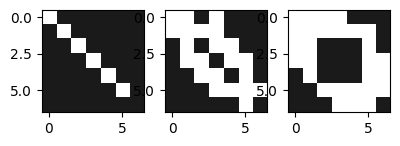

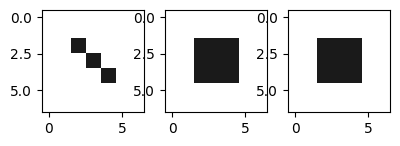

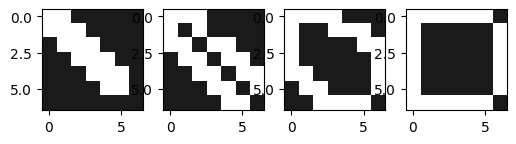

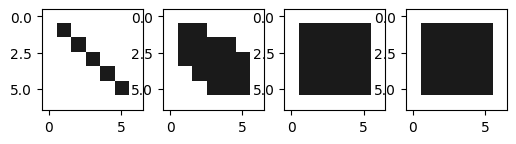

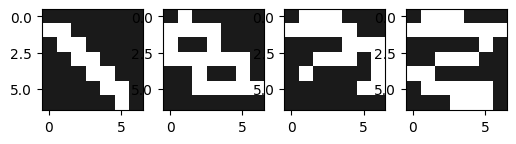

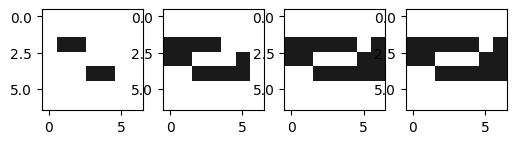

In [3]:
gamma = 0.99
beta = 0.5
def normalize_plot(ax,data):
    data=data/(data.max()-data.min())
    im = ax.imshow(data, cmap="gray", alpha=0.7)

l2_cost=[0.0001,0.001,0.0001,0.0001]
alphas=[0.002,0.001,0.001,0.005]
for id in [1,2,3,4]:
    occupancys, costs,f_divs,Vs = solve_V(
        f"setting{id}", gamma, 0.5,0.002,l2_cost[id-1]
    )
    end=f_divs.argmin()+1
    fig, axes = plt.subplots(1, end, figsize=(end*1.5, 4))
    for i in range(end):
        ax = axes[i]
        im = ax.imshow(occupancys[i], cmap="gray", alpha=0.9)

    fig, axes = plt.subplots(1, end, figsize=(end*1.5, 4))
    for i in range(end):
        ax = axes[i]
        im = ax.imshow(costs[min(i,end-2)]<cost_limit, cmap="gray", alpha=0.9)
